In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import  train_test_split
from textblob import TextBlob
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import math as math
import collections as collections
import random as random
from numpy.random import randint
import datetime
import pickle

In [3]:
# open twitter sentiment data
# 1 = positive
# 0 = Negative
twitter_data_df = pd.read_csv("../data/raw/Twitter_Sentiment_Analysis/Sentiment Analysis Dataset.csv",error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


# Load Data

In [4]:
twitter_data_df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [5]:
X_all = twitter_data_df.SentimentText

In [6]:
Y_all = twitter_data_df.Sentiment

In [7]:
twitter_data_df.shape

(1578612, 4)

In [8]:
X_t, X_val, Y_t, Y_val = train_test_split(X_all,Y_all, test_size=.20)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_t,Y_t, test_size=.10)

In [10]:
X_train.shape

(1136600,)

In [11]:
Y_train.shape

(1136600,)

In [12]:
X_test.shape

(126289,)

### Once this is done, we need to convert the sentences as a one-hot tensor of shape [sentence_length x word_length x alphabet_size].
- https://charlesashby.github.io/2017/06/05/sentiment-analysis-with-char-lstm/

In [202]:
EMB_ALPHABET = 'abcdefghijklmnopqrstuvwxyz0123456789-,;' \
               '.!?:\'"/\\|_@#$%^&*~`+-=<>()[]{}'
MAX_WORD_LENGTH = 16 # number of characters in a word
ALPHABET_SIZE = len(EMB_ALPHABET)
# we associate every character in our alphabet to a number: 
# e.g. b => 1 d => 3 etc.
ALPHABET_DICT = {ch: ix for ix, ch in enumerate(EMB_ALPHABET)}

In [203]:
def encode_one_hot( sentence, emb_alphabet, max_word_length, alphabet_size, alphabet_dict):
    """Convert a sentence to a one hot character encoding tensor for that sentence using alphanumeric characters"""
    # https://charlesashby.github.io/2017/06/05/sentiment-analysis-with-char-lstm/
    # Convert Sentences to np.array of Shape 
    # ('sent_length', 'word_length', 'emb_size')

    sent = []

    # We need to keep track of the maximum length of the sentence in a minibatch
    # so that we can pad them with zeros, this is why we return the length of every
    # sentences after they are converted to one-hot tensors
    SENT_LENGTH = 0

    # Here, we remove any non-printable characters in a sentence (mostly
    # non-ASCII characters)
    printable = emb_alphabet
    encoded_sentence = filter(lambda x: x in printable, sentence)

    # word_tokenize() splits a sentence into an array where each element is
    # a word in the sentence, for example, 
    # "My name is Charles" => ["My", "name", "is", Charles"]
    blob = TextBlob(sentence)
    individual_words_from_sentence = blob.tokenize()
    for word in individual_words_from_sentence :

        # Encode one word as a matrix of shape [max_word_length x ALPHABET_SIZE]
        word_encoding = np.zeros(shape=(max_word_length, alphabet_size))

        for i, char in enumerate(word):

            # If the character is not in the alphabet, ignore it    
            try:
                char_encoding = alphabet_dict[char]
                one_hot = np.zeros(ALPHABET_SIZE)
                one_hot[char_encoding] = 1
                word_encoding[i] = one_hot

            except Exception as e:
                pass

        sent.append(np.array(word_encoding))
        SENT_LENGTH += 1

    return np.array(sent), SENT_LENGTH

In [204]:
array,length = encode_one_hot(X_all[1], EMB_ALPHABET , MAX_WORD_LENGTH, ALPHABET_SIZE, ALPHABET_DICT)
# array is number of words in sentence X Max word length  X one hot encoding for alphabet

# Pad tensors to all have the same size 
- [batch_size x maximum_sentence_length x maximum_word_length x alphabet_size]

In [16]:
X_all[0][2:-1]

'                   is so sad for my APL friend............'

In [340]:
def make_minibatch( sentences, sentiment_y,  max_word_length, alphabet_size):
    """Create a minibath of one-hot encoded sentences 
    array is Batch Size X max number of words in sentence X Max word length  X one hot encoding for alphabet,
    
    and one hot encoded y [0,1] or [1,0] whre 1=positive"""
    # Create a minibatch of sentences and convert sentiment
    # to a one-hot vector, also takes care of padding

    max_word_length = max_word_length
    minibatch_x = []
    minibatch_y = []
    max_length = 0

    for sentence,sent in zip(sentences, sentiment_y):
        # Append the one-hot encoding of the sentiment to the minibatch of Y
        # 0: Negative 1: Positive
        minibatch_y.append(np.array([0, 1]) if sent == 0 else np.array([1, 0]))

        # One-hot encoding of the sentence
        one_hot, length = encode_one_hot(sentence,EMB_ALPHABET, MAX_WORD_LENGTH, ALPHABET_SIZE, ALPHABET_DICT )

        # Calculate maximum_sentence_length
        if length >= max_length:
            max_length = length

        # Append encoded sentence to the minibatch of X
        minibatch_x.append(one_hot)


    # data is a np.array of shape ('b', 's', 'w', 'e') we want to
    # pad it with np.zeros of shape ('e',) to get 
    # ('b', 'SENTENCE_MAX_LENGTH', 'WORD_MAX_LENGTH', 'e')
    def numpy_fillna(data):
        """ This is a very useful function that fill the holes in our tensor """

        # Get lengths of each row of data
        lens = np.array([len(i) for i in data])

        # Mask of valid places in each row
        mask = np.arange(lens.max()) < lens[:, None]
        #print(mask)

        # Setup output array and put elements from data into masked positions
        out = np.zeros(shape=(mask.shape + (max_word_length, alphabet_size)),
                       dtype='float32')
        #print(out)

        out[mask] = np.concatenate(data)
        #print(out,'final')
        return out

    # Padding...
    minibatch_x = numpy_fillna(minibatch_x)

    return minibatch_x, np.array(minibatch_y)

In [18]:
minibatch_x, minibatch_y = make_minibatch(X_test[:15],Y_test[:15], MAX_WORD_LENGTH, ALPHABET_SIZE)

In [19]:
minibatch_x.shape

(15, 36, 16, 69)

## Make a generator to feed to our network

In [336]:
def iterate_minibatch(batch_size, X_data, y_data):
        """ Returns Next Batch """
        
        n_samples = len(X_data)
        
        # Number of batches / number of iterations per epoch
        n_batch = int(n_samples // batch_size)
        
        # Creates a minibatch, loads it to RAM and feed it to the network
        # until the buffer is empty
        for i in range(n_batch):

            inputs, targets = make_minibatch(X_data[max(batch_size*i-batch_size,0):max(batch_size*i,batch_size)],\
                                             y_data[max(batch_size*i-batch_size,0):max(batch_size*i,batch_size)],\
                                             MAX_WORD_LENGTH, ALPHABET_SIZE)
            yield inputs, targets

# Define the network

In [20]:


def conv2d(input_, output_dim, k_h, k_w, name="conv2d"):
    """ Straight-forward convvolutional layer """
    # w is the kernel, b the bias, no strides and VALID padding
    
    g = tf.get_default_graph()
    with g.as_default():

        with tf.variable_scope(name):
            w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim])
            b = tf.get_variable('b', [output_dim])

        return tf.nn.conv2d(input_, w, strides=[1, 1, 1, 1], padding='VALID') + b

In [21]:
def tdnn(input_, kernels, kernel_features, ALPHABET_SIZE, scope='TDNN'):
    ''' Time Delay Neural Network
    :input:           input float tensor of shape 
                      [(batch_size*num_unroll_steps) x max_word_length x embed_size]
    :kernels:         array of kernel sizes
    :kernel_features: array of kernel feature sizes (parallel to kernels)
    '''
    assert len(kernels) == len(kernel_features), 'Kernel and Features must have the same size'

    # input_ is a np.array of shape ('b', 'sentence_length', 'max_word_length', 'embed_size') we
    # need to convert it to shape ('b * sentence_length', 1, 'max_word_length', 'embed_size') to
    # use conv2D
    # It might not seem obvious why we need to use this small hack at first sight, the reason
    # is that sentence_length will change across the different minibatches, but if we kept it
    # as is sentence_length would act as the number of channels in the convnet which NEEDS to
    # stay the same
    input_ = tf.reshape(input_, [-1, MAX_WORD_LENGTH, ALPHABET_SIZE])
    input_ = tf.expand_dims(input_, 1)

    layers = []
    g = tf.get_default_graph()
    with g.as_default():
        with tf.variable_scope(scope):
            for kernel_size, kernel_feature_size in zip(kernels, kernel_features):
                reduced_length = MAX_WORD_LENGTH - kernel_size + 1

                # [batch_size * sentence_length x max_word_length x embed_size x kernel_feature_size]
                conv = conv2d(input_, kernel_feature_size, 1,
                              kernel_size, name="kernel_%d" % kernel_size)

                # [batch_size * sentence_length x 1 x 1 x kernel_feature_size]
                pool = tf.nn.max_pool(tf.tanh(conv), [1, 1, reduced_length, 1], [1, 1, 1, 1], 'VALID')

                layers.append(tf.squeeze(pool, [1, 2]))

            if len(kernels) > 1:
                output = tf.concat(layers, 1)
            else:
                output = layers[0]

    return output

In [22]:
# This goes in ops.py

def linear(input_, output_size, scope=None):
    """
    Linear map: output[k] = sum_i(Matrix[k, i] * args[i] ) + Bias[k]
    
    Args:
        args: a tensor or a list of 2D, batch x n, Tensors.
        output_size: int, second dimension of W[i].
        scope: VariableScope for the created subgraph; defaults to "Linear".
        
    Returns:
        A 2D Tensor with shape [batch x output_size] equal to
        sum_i(args[i] * W[i]), where W[i]s are newly created matrices.
        
    Raises:
        ValueError: if some of the arguments has unspecified or wrong shape.
    """
    
    shape = input_.get_shape().as_list()
    if len(shape) != 2:
        raise ValueError("Linear is expecting 2D arguments: %s" % str(shape))
    if not shape[1]:
        raise ValueError("Linear expects shape[1] of arguments: %s" % str(shape))
    input_size = shape[1]
    g = tf.get_default_graph()
    with g.as_default():

        # Now the computation.
        with tf.variable_scope(scope or "SimpleLinear"):
            matrix = tf.get_variable("Matrix", [output_size, input_size],
                                     dtype=input_.dtype)
            bias_term = tf.get_variable("Bias", [output_size], dtype=input_.dtype)

    return tf.matmul(input_, tf.transpose(matrix)) + bias_term

# Highway network to help train deep models

In [23]:
def highway(input_, size, num_layers=1, bias=-2.0, f=tf.nn.relu, scope='Highway'):
    """Highway Network (cf. http://arxiv.org/abs/1505.00387).
    t = sigmoid(Wy + b)
    z = t * g(Wy + b) + (1 - t) * y
    where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
    """
    g = tf.get_default_graph()
    with g.as_default():

        with tf.variable_scope(scope):
            for idx in range(num_layers):
                g = f(linear(input_, size, scope='highway_lin_%d' % idx))

                t = tf.sigmoid(linear(input_, size, scope='highway_gate_%d' % idx) + bias)

                output = t * g + (1. - t) * input_
                input_ = output

    return output

# LSTM model

In [24]:

class LSTM(object):
    """ Character-Level LSTM Implementation """

    def __init__(self, hparams=None):
        # Get the hyperparameters
        self.hparams = self.get_hparams()
        g = tf.get_default_graph()
        with g.as_default():
        
            # maximum length of each words
            max_word_length = self.hparams['max_word_length']

            # X is of shape ('b', 'sentence_length', 'max_word_length', 'alphabet_size']
            # Placeholder for the one-hot encoded sentences
            X = tf.placeholder('float32', 
                                    shape=[None, None, max_word_length, ALPHABET_SIZE],
                                    name='X')
            self.X = X

            # Placeholder for the one-hot encoded sentiment
            Y = tf.placeholder('float32', shape=[None, 2], name='Y')
            self.Y = Y
        
    def get_hparams(self):
        ''' Get Hyperparameters '''

        return {
            'BATCH_SIZE':       64,
            'EPOCHS':           500,
            'max_word_length':  16,
            'learning_rate':    0.0001,
            'patience':         10000,
        }

In [25]:
lstm = LSTM()

In [26]:
X = lstm.X # tf placeholder 
Y = lstm.Y # tf placeholder for class variable

In [27]:
lstm.get_hparams()

{'BATCH_SIZE': 64,
 'EPOCHS': 500,
 'learning_rate': 0.0001,
 'max_word_length': 16,
 'patience': 10000}

In [28]:
def softmax(input_, out_dim, scope=None):
    """ SoftMax Output """
    
    g = tf.get_default_graph()
    with g.as_default():

        with tf.variable_scope(scope or 'softmax'):
            W = tf.get_variable('W', [input_.get_shape()[1], out_dim])
            b = tf.get_variable('b', [out_dim])

    return tf.nn.softmax(tf.matmul(input_, W) + b)

In [29]:
X_train.shape

(1136600,)

In [30]:
X_test.shape

(126289,)

In [31]:
prediction = None # class variable
train_samples=1136600
valid_samples = 126289
def build(
              training=True,
              testing_batch_size=1000,
              kernels=[1, 2, 3, 4, 5, 6, 7],
              kernel_features=[25, 50, 75, 100, 125, 150, 175],
              rnn_size=650,
              dropout=0.0,
              size=700,
              train_samples=train_samples,
              valid_samples=valid_samples,
              hparams= lstm.get_hparams()):
        """
        Build the computational graph
        
        :param training: 
            Boolean whether we are training (True) or testing (False)
        
        :param testing_batch_size: 
            Batch size to use during testing 
            
        :param kernels:
            Kernel width for each convolutional layer
         
        :param kernel_features: 
            Number of kernels for each convolutional layer
            
        :param rnn_size: 
            Size of the LSTM output
        
        :param dropout: 
            Retain probability when using dropout
        
        :param size: 
            Size of the Highway embeding
        
        :param train_samples: 
            Number of training samples
        
        :param valid_samples: 
            Number of validation samples
        :hyperparameters
            dict of parameters
        """

        max_word_length = hparams['max_word_length']
        size = size
        max_word_length = hparams['max_word_length']
        train_samples = train_samples
        valid_samples = valid_samples

        
        # If we are training use the BATCH_SIZE from the hyperparameters
        # else use the testing batch size
        if training == True:
            BATCH_SIZE = hparams['BATCH_SIZE']

        else:
            BATCH_SIZE = testing_batch_size
            
       

        
        # Pass the sentences through the CharCNN network
        cnn = tdnn(X, kernels, kernel_features, ALPHABET_SIZE) # X is a TF placeholder from the LSTM network

        # tdnn() returns a tensor of shape [batch_size * sentence_length x kernel_features]
        # highway() returns a tensor of shape [batch_size * sentence_length x size] to use
        # tensorflow dynamic_rnn module we need to reshape it to 
        # [batch_size x sentence_length x size]
        cnn = highway(cnn, size)

        cnn = tf.reshape(cnn, [BATCH_SIZE, -1, size])
        # deafult graph
        g = tf.get_default_graph()
        with g.as_default():
        
            # Build the LSTM
            with tf.variable_scope('LSTM'):

                # The following is pretty straight-forward, create a cell and add dropout if
                # necessary. Note that I did not use dropout to get my results, but using it
                # will probably help
                def create_rnn_cell():
                    cell = rnn.BasicLSTMCell(rnn_size, state_is_tuple=True,
                                             forget_bias=0.0, reuse=False)

                    if dropout > 0.0:
                        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=1. - dropout)

                    return cell

                cell = create_rnn_cell()

                # Initial state of the LSTM cell
                initial_rnn_state = cell.zero_state(BATCH_SIZE, dtype='float32')

                # This function returns the outputs at every steps of 
                # the LSTM (i.e. one output for every word)
                outputs, final_rnn_state = tf.nn.dynamic_rnn(cell, cnn,
                                                             initial_state=initial_rnn_state,
                                                             dtype=tf.float32)


                # In this implementation, we only care about the last outputs of the RNN
                # i.e. the output at the end of the sentence
                outputs = tf.transpose(outputs, [1, 0, 2])
                last = outputs[-1]
            global prediction
            prediction = softmax(last, 2)
        


size = None
hparams = None
max_word_length = None


build(hparams=lstm.get_hparams())

In [32]:
lstm.get_hparams()

{'BATCH_SIZE': 64,
 'EPOCHS': 500,
 'learning_rate': 0.0001,
 'max_word_length': 16,
 'patience': 10000}

In [33]:
prediction

<tf.Tensor 'Softmax:0' shape=(64, 2) dtype=float32>

In [34]:
# PATH = '/NOBACKUP/ashbylepoc/PycharmProjects/CharLSTM/'
# TRAIN_SET = PATH + 'datasets/train_set.csv'
# TEST_SET = PATH + 'datasets/test_set.csv'
# VALID_SET = PATH + 'datasets/valid_set.csv'

SAVE_PATH = 'tensorflow/lstm'
LOGGING_PATH = 'tensorflow/log.txt'

In [35]:
def train(hparams, X_train, Y_train, X_test, Y_test, load_model = False):
    
    
    
    BATCH_SIZE = hparams['BATCH_SIZE']
    EPOCHS = hparams['EPOCHS']
    max_word_length = hparams['max_word_length']
    learning_rate = hparams['learning_rate']

    # the probability for each sentiment (pos, neg)
    pred = prediction

    # Binary cross-entropy loss
    cost = - tf.reduce_sum(Y * tf.log(tf.clip_by_value(pred, 1e-10, 1.0)))

    # The number of "predictions" we got right, we assign a sentence with 
    # a positive connotation when the probability to be positive is greater then
    # the probability of being negative and vice-versa.
    predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))

    # Accuracy: # predictions right / total number of predictions
    acc = tf.reduce_mean(tf.cast(predictions, 'float32'))

    # We use the Adam Optimizer
    
    try: # see if this optimizer is already defined
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam').minimize(cost)
    except:
        pass
    


    n_batch = train_samples // BATCH_SIZE # train samples is class variable

    # parameters for saving and early stopping
    saver = tf.train.Saver()

    patience = hparams['patience']
    
    
   # tf.add_to_collection('train_op', train_op) ## for the variables to be restores
    
    # get graph
    g = tf.get_default_graph()


    with tf.Session(graph = g) as sess:
        sess.run(tf.global_variables_initializer())
        best_acc = 0.0
        DONE = False
        epoch = 0
        g_step = 0
        if load_model == True:
            saver = tf.train.import_meta_graph('./tensorflow/lstm.meta') #.mets is the model
            saver.restore(sess, tf.train.latest_checkpoint('./tensorflow/')) # directory where model was saved
            all_vars = tf.get_collection('vars') # restore all vars in the graph
            for v in all_vars:
                v_ = sess.run(v)
                print(v_)
            print("Finished loading model")

        while epoch <= EPOCHS and not DONE:
            loss = 0.0
            batch = 1
            epoch += 1

#             with open(TRAIN_SET, 'r') as f:
#                 # Load the file in a TextReader object until we've read it all
#                 # then create a new TextReader Object for how many epochs we 
#                 # want to loop on
#                 reader = TextReader(f, max_word_length)
                
            for minibatch in iterate_minibatch(BATCH_SIZE, X_train, Y_train):
                g_step +=1
                batch_x, batch_y = minibatch

                # Do backprop and compute the cost and accuracy on this minibatch
                _, c, a = sess.run([optimizer, cost, acc],
                                   feed_dict={X: batch_x, Y: batch_y})

                loss += c

                if batch % 10 == 0: # change back to 100
                    # Compute Accuracy on the Training set and print some info
                    print('Epoch: %5d/%5d -- batch: %5d/%5d -- Loss: %.4f -- Train Accuracy: %.4f -- Patience %.4f' %
                          (epoch, EPOCHS, batch, n_batch, loss/batch, a, patience))

                    # Write loss and accuracy to some file
                    log = open(LOGGING_PATH, 'a')
                    log.write('%s, %6d, %.5f, %.5f \n' % ('train', epoch * batch, loss/batch, a))
                    log.close()
                    

                # --------------
                # EARLY STOPPING
                # --------------

                # Compute Accuracy on the Validation set, check if validation has improved, save model, etc
                if batch % 500 == 0:
                    m = 1
                    accuracy = []

                    # Validation set is very large, so accuracy is computed on testing set
                    # instead of valid set, change TEST_SET to VALID_SET to compute accuracy on valid set
#                     with open(TEST_SET, 'r') as ff:
#                         valid_reader = TextReader(ff, max_word_length)
                    for mb in iterate_minibatch(BATCH_SIZE, X_test, Y_test):
                        valid_x, valid_y = mb
                        a = sess.run([acc], feed_dict={X: valid_x, Y: valid_y}) # X and Y are placeholder nodes
                        accuracy.append(a)
                        m +=1
                        if m == 10: # to speed up training only go through 10 batches 
                            break
 
                    mean_acc = np.mean(accuracy)

                    # if accuracy has improved, save model and boost patience
                    if mean_acc > best_acc:
                        best_acc = mean_acc
                        save_path = saver.save(sess, SAVE_PATH, global_step=g_step)
                        patience = hparams['patience']
                        print('Model saved in file: %s' % save_path)

                    # else reduce patience and break loop if necessary
                    else:
                        patience -= 500
                        if patience <= 0:
                            DONE = True
                            break

                    print('Epoch: %5d/%5d -- batch: %5d/%5d -- Valid Accuracy: %.4f' %
                         (epoch, EPOCHS, batch, n_batch, mean_acc))

                    # Write validation accuracy to log file
                    log = open(LOGGING_PATH, 'a')
                    log.write('%s, %6d, %.5f \n' % ('valid', epoch * batch, mean_acc))
                    log.close()

                batch += 1

In [36]:
# Try to train the model

In [ ]:
train(lstm.get_hparams(),X_train, Y_train, X_test, Y_test, load_model=False)

In [ ]:
def evaluate_test_set(hparams, X_val, Y_val):
        """
        Evaluate Test Set
        On a model that trained for around 5 epochs it achieved:
        # Valid loss: 23.50035 -- Valid Accuracy: 0.83613
        """
        BATCH_SIZE = hparams['BATCH_SIZE']
        max_word_length = hparams['max_word_length']

        pred = prediction
        
        cost = - tf.reduce_sum(Y * tf.log(tf.clip_by_value(pred, 1e-10, 1.0)))

        predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))

        acc = tf.reduce_mean(tf.cast(predictions, 'float32'))

        # restart the graph
        tf.reset_default_graph()
        # parameters for restoring variables
        
    
        #saver = tf.train.Saver()
        #saver = tf.train.import_meta_graph('./tensorflow/lstm.meta')

        with tf.Session() as sess:
            print('Loading model %s...' % SAVE_PATH)
            saver = tf.train.import_meta_graph('./tensorflow/lstm.meta')
            var = tf.global_variables()[0]
            print(var)
            sess.run(tf.global_variables_initializer())
            
            
            saver.restore(sess, SAVE_PATH)
            print('Done!')
            loss = []
            accuracy = []

#             with open(VALID_SET, 'r') as f:
#                 reader = TextReader(f, max_word_length)
            for minibatch in iterate_minibatch(BATCH_SIZE, X_val, Y_val):
                batch_x, batch_y = minibatch

                c, a = sess.run([cost, acc], feed_dict={X: batch_x, Y: batch_y}) # X and Y are placeholder variables
                loss.append(c)
                accuracy.append(a)

            loss = np.mean(loss)
            accuracy = np.mean(accuracy)
            print('Valid loss: %.5f -- Valid Accuracy: %.5f' % (loss, accuracy))
            return loss, accuracy

In [ ]:
evaluate_test_set(lstm.get_hparams(),X_val,Y_val)

In [41]:
with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        best_acc = 0.0
        DONE = False
        epoch = 0
        g_step = 0
        #if load_model == True:
        saver = tf.train.import_meta_graph('./tensorflow/lstm.meta') #.mets is the model
        saver.restore(sess, tf.train.latest_checkpoint('./tensorflow/')) # directory where model was saved
        all_vars = tf.get_collection('vars') # restore all vars in the graph
        for v in all_vars:
            v_ = sess.run(v)
            print(v_)
        print("Finished loading model")

INFO:tensorflow:Restoring parameters from ./tensorflow/lstm
Finished loading model


In [43]:
lstm.get_hparams()

{'BATCH_SIZE': 64,
 'EPOCHS': 500,
 'learning_rate': 0.0001,
 'max_word_length': 16,
 'patience': 10000}

In [91]:
with tf.Session() as sess:
    print('Loading model %s...' % SAVE_PATH)
    saver = tf.train.import_meta_graph('./tensorflow/lstm.meta') #.mets is the model
    saver.restore(sess, tf.train.latest_checkpoint('./tensorflow/')) # directory where model was saved
    all_vars = tf.get_collection('vars') # restore all vars in the graph
    for v in all_vars:
        v_ = sess.run(v)
        print(v_,'Var')
    print("Done!")
    
    pred = prediction


    cost = - tf.reduce_sum(Y * tf.log(tf.clip_by_value(pred, 1e-10, 1.0)))

    predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))

    acc = tf.reduce_mean(tf.cast(predictions, 'float32'))
        
    loss = []
    accuracy = []
        
    for minibatch in iterate_minibatch(BATCH_SIZE, X_val, Y_val):
            batch_x, batch_y = minibatch

            c, a = sess.run([cost, acc], feed_dict={X: batch_x, Y: batch_y}) # X and Y are placeholder variables
            loss.append(c)
            accuracy.append(a)

    loss = np.mean(loss)
    accuracy = np.mean(accuracy)
    print('Valid loss: %.5f -- Valid Accuracy: %.5f' % (loss, accuracy))
    print(loss, accuracy)
    

Loading model tensorflow/lstm...
INFO:tensorflow:Restoring parameters from ./tensorflow/lstm
Done!


ValueError: Tensor("Const_6:0", shape=(2,), dtype=int32) must be from the same graph as Tensor("mul_5:0", shape=(64, 2), dtype=float32).

In [92]:
g = tf.get_default_graph()

In [55]:
BATCH_SIZE =64 #hparams['BATCH_SIZE']
max_word_length = 16#hparams['max_word_length']


with tf.Session() as sess:
    print('Loading model %s...' % SAVE_PATH)
    saver = tf.train.import_meta_graph('./tensorflow/lstm.meta') #.mets is the model
    saver.restore(sess, tf.train.latest_checkpoint('./tensorflow/')) # directory where model was saved
    all_vars = tf.get_collection('vars') # restore all vars in the graph
    for v in all_vars:
        v_ = sess.run(v)
        print(v_,'Var')
    print("Finished loading model")
    print('Done!')
    g = tf.get_default_graph()
    print(g,'graph')
    with g.as_default():

        pred = prediction

        cost = - tf.reduce_sum(Y * tf.log(tf.clip_by_value(pred, 1e-10, 1.0)))

        predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))

        acc = tf.reduce_mean(tf.cast(predictions, 'float32'))

        # # restart the graph
        # tf.reset_default_graph()
        # parameters for restoring variables

        #saver = tf.train.Saver()
        #saver = tf.train.import_meta_graph('./tensorflow/lstm.meta')


        loss = []
        accuracy = []

        #             with open(VALID_SET, 'r') as f:
        #                 reader = TextReader(f, max_word_length)
        for minibatch in iterate_minibatch(BATCH_SIZE, X_val, Y_val):
            batch_x, batch_y = minibatch

            c, a = sess.run([cost, acc], feed_dict={X: batch_x, Y: batch_y}) # X and Y are placeholder variables
            loss.append(c)
            accuracy.append(a)

        loss = np.mean(loss)
        accuracy = np.mean(accuracy)
        print('Valid loss: %.5f -- Valid Accuracy: %.5f' % (loss, accuracy))
        print(loss, accuracy)

Loading model tensorflow/lstm...
INFO:tensorflow:Restoring parameters from ./tensorflow/lstm
Finished loading model
Done!
<tensorflow.python.framework.ops.Graph object at 0x11a6441d0> graph


ValueError: Tensor("Const_6:0", shape=(2,), dtype=int32) must be from the same graph as Tensor("mul_7:0", shape=(64, 2), dtype=float32).

In [12]:
Y

NameError: name 'Y' is not defined

In [ ]:
minibatch_x.shape

In [ ]:
minibatch_x.shape

In [ ]:
x_1 , l = encode_one_hot(X_all[1],EMB_ALPHABET, MAX_WORD_LENGTH, ALPHABET_SIZE, ALPHABET_DICT )

In [ ]:
x_2 , l = encode_one_hot(X_all[2],EMB_ALPHABET, MAX_WORD_LENGTH, ALPHABET_SIZE, ALPHABET_DICT )

In [ ]:
x_1.shape

In [ ]:
x_2.shape

# Goal is to train two models - LSTM and CNN to sentiment analysis
- Using tweets here because the primary source of text from founders will be Tweets

# Try creating a toy model
- save and load

# New Attempt
- Use multilayer perceptron  with count vectorizer to predict sentiment

In [15]:
X_all[0]

'                     is so sad for my APL friend.............'

In [16]:
Y_all[0]

0

In [17]:
# Downsample

X_down = X_all[:80_000]
Y_down = Y_all[:80_000]


In [18]:
Y_down = [[1,0] if i == 1 else [0,1] for i in Y_down]

In [19]:
m_features = 10_000

In [20]:
count_vec = CountVectorizer(max_features=m_features)
# try also TFIDF
tfidf_vec = TfidfVectorizer(max_features=m_features)

In [21]:
#X_cvectors = count_vec.fit_transform(X_down)
X_cvectors = tfidf_vec.fit_transform(X_down)


In [22]:
X_dense =  np.array(X_cvectors.todense())

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_dense, Y_down, test_size=.5)

In [24]:
t = np.random.shuffle(X_down)

In [56]:
def batch_generator(batch_size, X, Y, shuffle=True):
    """Return a generator of batches for X and Y data"""
    # shuffle the examples
    if shuffle:
        np.random.shuffle(X)
        np.random.shuffle(Y)
    
    for i in range(0,len(X),batch_size):
        yield X[i:i+batch_size], np.array(Y[i:i+batch_size])

In [26]:
x,y = next(batch_generator(16, X_train, y_train))

In [27]:
x.shape

(16, 10000)

In [28]:
y.shape

(16, 2)

### Multilayer perceptron for sentiment analysis first

In [34]:

# Parameters
learning_rate = 0.01
training_epochs = 200
batch_size = 128
display_step = 10

EMB_ALPHABET = 'abcdefghijklmnopqrstuvwxyz0123456789-,;' \
               '.!?:\'"/\\|_@#$%^&*~`+-=<>()[]{}'
MAX_WORD_LENGTH = 16 # number of characters in a word
ALPHABET_SIZE = len(EMB_ALPHABET)
# we associate every character in our alphabet to a number: 
# e.g. b => 1 d => 3 etc.
ALPHABET_DICT = {ch: ix for ix, ch in enumerate(EMB_ALPHABET)}

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_hidden_3 = 256
n_input = m_features # max features
n_classes = 2 # sentiment (0 = negative, 1 = positive)



# save path
SAVE_PATH = 'tensorflow/MLP_sentiment_tfidf'

In [35]:

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # hidden 3
    layer_3 = tf.add(tf.matmul(layer_1, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    #output
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    return out_layer

In [41]:
tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer

#### maybe change the loss here to binary cross entropy 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
 # Minimize error using cross entropy
#cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [42]:
 # Initial training session
    
    ### DON"T LAUNCH
# Launch the graph
# with tf.Session() as sess:
#     # Initializing the variables
#     sess.run(init)
    
#     # accuracy calculation
#     correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#     acc = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))
    

#     # Training cycle
#     for epoch in range(training_epochs):
#         # set up the training generators
#         gen_train = batch_generator(16, X_train, y_train)
#         gen_test = batch_generator(16,X_test, y_test)
    
#         avg_cost = 0.
#         total_batch = int(len(X_train)/batch_size)
      

        
#         # Loop over all batches
#         for i in range(total_batch):
#             batch_x, batch_y = next(gen_train)
#             test_x, test_y = next(gen_test)
#             # Run optimization op (backprop) and cost op (to get loss value)
#             _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
#                                                           y: batch_y})
            
#             #a = sess.run([acc], feed_dict={x:test_x, y:test_y})
#             # Compute average loss
#             avg_cost += c / total_batch
#         # Display logs per epoch step
#         if epoch % display_step == 0:
#             print( "Epoch:", '%04d' % (epoch+1), "cost=", \
#                 "{:.9f}".format(c))
#             print("Average cost =",avg_cost)
#             print("Accuracy:", acc.eval({x: test_x, y: test_y}))

#              #Save model weights to disk
#             saver = tf.train.Saver()
#             save_path = saver.save(sess=sess, save_path = SAVE_PATH)
#             print("Model saved in file: %s" % SAVE_PATH)
            
#     print("Optimization Finished!")



Epoch: 0001 cost= 5.768409729
Average cost = 30.5418810027
Accuracy: 0.75
Model saved in file: tensorflow/MLP_sentiment_tfidf
Epoch: 0011 cost= 1.405854344
Average cost = 1.47460775756
Accuracy: 0.5625
Model saved in file: tensorflow/MLP_sentiment_tfidf
Epoch: 0021 cost= 0.647772312
Average cost = 0.80973352062
Accuracy: 0.5625
Model saved in file: tensorflow/MLP_sentiment_tfidf
Epoch: 0031 cost= 0.667012453
Average cost = 0.693808201796
Accuracy: 0.5
Model saved in file: tensorflow/MLP_sentiment_tfidf
Epoch: 0041 cost= 0.652975202
Average cost = 0.692506928283
Accuracy: 0.375
Model saved in file: tensorflow/MLP_sentiment_tfidf
Epoch: 0051 cost= 0.710689425
Average cost = 0.689293405566
Accuracy: 0.875
Model saved in file: tensorflow/MLP_sentiment_tfidf
Epoch: 0061 cost= 0.669481099
Average cost = 0.688162672596
Accuracy: 0.5625
Model saved in file: tensorflow/MLP_sentiment_tfidf
Epoch: 0071 cost= 0.712082744
Average cost = 0.688471787824
Accuracy: 0.5625
Model saved in file: tensorflo

In [301]:
# Load an existing model
tf.reset_default_graph()
list_of_acc = []
print("Starting 2nd session...")
with tf.Session() as sess:
  
    
    
    ## Create the graph
    # tf Graph input
    x = tf.placeholder("float", [None, n_input])
    y = tf.placeholder("float", [None, n_classes])


   # Store layers weight & bias
    weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
    }
    biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }

    # Construct model
    pred = multilayer_perceptron(x, weights, biases)

    # Define loss and optimizer

    #### maybe change the loss here to binary cross entropy 
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    
    # Initializing the variables
    init = tf.global_variables_initializer()



    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore model weights from previously saved model
    saver = tf.train.Saver()
    load_path = saver.restore(sess, SAVE_PATH)
    print("Model restored from file: %s" % SAVE_PATH)

    # accuracy calculation
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

    # Training cycle
    for epoch in range(training_epochs):
        # set up the training generators
        gen_train = batch_generator(16, X_train, y_train)
        gen_test = batch_generator(16,X_test, y_test)
    
        avg_cost = 0.
        total_batch = int(len(X_train)/batch_size)
        

        
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = next(gen_train)
            test_x, test_y = next(gen_test)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            
            #a = sess.run([acc], feed_dict={x:test_x, y:test_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print( "Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(c))
            print("Average cost =",avg_cost)
            print("Accuracy:", acc.eval({x: test_x, y: test_y}))
            list_of_acc.append(acc.eval({x: test_x, y: test_y}))

             #Save model weights to disk
            saver = tf.train.Saver()
            save_path = saver.save(sess=sess, save_path = SAVE_PATH)
            print("Model saved in file: %s" % SAVE_PATH)
            
            
    print("Optimization Finished!")


Starting 2nd session...
INFO:tensorflow:Restoring parameters from tensorflow/MLP_sentiment_tfidf
Model restored from file: tensorflow/MLP_sentiment_tfidf


KeyError: 1136596

### LSTM with Tensorflow

In [37]:
Y_lstm = [[1,0] if i == 1 else [0,1] for i in Y_all]

In [38]:
X_lstm = X_all

In [39]:
X_train_lstm,  X_test_lstm,y_train_lstm, y_test_lstm = train_test_split(X_lstm,Y_lstm, test_size=.2)

In [40]:
X_small_train, y_small_train = X_all[:100], np.array(Y_lstm[:100])

- Make balanced classes

In [73]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [80]:
np.array(X_all[:1000]).reshape(-1,1)

(1000, 1)

In [105]:
X_small_train, y_t= balanced_subsample(np.array(X_all[:1000]).reshape(-1,1),np.array(Y_all[:1000]))

In [84]:
X_small_train.shape

(662, 1)

In [106]:
y_small_train = np.array([[1,0] if i == 1 else [0,1] for i in y_t])

### First, define the embedding matrix
- https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [17]:
vocabulary_size = 50_000

In [18]:
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

In [23]:
data_set_words = []
for tweet in X_all: # add words to str
    for word in tweet.split(' '):
        data_set_words.append(word)

In [24]:
data_set_words [:10]

['', '', '', '', '', '', '', '', '', '']

In [25]:
data_build_dataset, count, dictionary, reverse_dictionary = build_dataset(data_set_words,vocabulary_size)

In [28]:
data_index = 0

In [29]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch_skip_gram(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    data_index = (data_index + 1) % len(data_build_dataset)
    buffer.append(data_build_dataset[data_index])
    
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data_build_dataset[data_index])
    data_index = (data_index + 1) % len(data_build_dataset)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data_build_dataset) - span) % len(data_build_dataset)
  return batch, labels

In [30]:
batch_, labels_ = generate_batch_skip_gram(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch_[i], reverse_dictionary[batch_[i]],
        '->', labels_[i, 0], reverse_dictionary[labels_[i, 0]])

1  -> 1 
1  -> 1 
1  -> 1 
1  -> 1 
1  -> 1 
1  -> 1 
1  -> 1 
1  -> 1 


In [475]:
dictionary['she']

130

In [476]:
reverse_dictionary[130]

'she'

In [478]:
labels_

array([[  37],
       [ 115],
       [   2],
       [  37],
       [  37],
       [5768],
       [  37],
       [   1]], dtype=int32)

### Building the graph

In [44]:
# Step 4: Build and train a skip-gram model.

max_tweet_length = 20 # Max number of words for a tweet
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector. Number of words per tweet
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [602]:
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

In [603]:
nce_weights = tf.Variable(
  tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [604]:
# Placeholders for inputs
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [605]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [606]:
# Compute the NCE loss, using a sample of the negative labels each time.
loss = tf.reduce_mean(
  tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocabulary_size))

In [495]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocabulary_size))
    
    # We use the SGD optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)
    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)
    
    # Add variable initializer.
    init = tf.global_variables_initializer()

In [498]:
# Step 5: Begin training.
num_steps = 100_001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch_skip_gram(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  284.950469971
Nearest to going: donut, stitches, HE, carefree, NM, ditto!, Cop, 'hi,
Nearest to good: ino, Lunch,, knuckles, corporate, (If, :I, fantastic!!!, cant,,
Nearest to off: Vince, lactose, concert,, Lloyd, skinned, summmer, glamour, Bonding,
Nearest to too: WHEN, crossed., construction, retweet., hobo, reason., mere, plate.,
Nearest to last: links., find,, clearing, Wana, pooped, Jen!, FEW, boring.,
Nearest to am: True,, &quot;its, FINALLY., xrays, Kerry, CRAP, @nickjfrost, vocabulary,
Nearest to this: Revolution, no!!!!, insomnia!, flames, greatly., devil, accounts,, uh,,
Nearest to you: training., @ToddBrink, @jaykpurdy, @vagelisv, soundly, medieval, smug, Holland,
Nearest to in: ADORABLE, reminder,, easy?, WSOP, messy, GMT, graduated!, Buddha,
Nearest to but: Bournemouth, Aquarium, @JessicaGottlieb, yummy!, babyshower, Crossing, there), @staaceeyy,
Nearest to it's: school,, expires, quiet,, on-line, Notts, Possible, Canon, sims3,
Neare

Nearest to been: got, @EvilNanny, EXAMS, still, @freddurst, two!, be, Friends,
Average loss at step  52000 :  4.77008590341
Average loss at step  54000 :  4.87522189641
Average loss at step  56000 :  4.6689874723
Average loss at step  58000 :  4.82599947155
Average loss at step  60000 :  4.95457962716
Nearest to going: @jamieharrington, @jeweljk, #seb-day, #alltimelow, go, getting, supposed, having,
Nearest to good: great, bad, @songzyuuup, long, #alltimelow, nice, hard, #seb-day,
Nearest to off: back, #frenchieb-day, #wnbaopeningday, Hot!, @flicka47, @Jamerichin, concert,, @fan4lyf,
Nearest to too: so, very, @emalea, end.., soo, Haha..., really, @Jason_Manford,
Nearest to last: fricken, @ExocetAU, best, encouraging, selective, pooped, #tokiohotel, GUESS,
Nearest to am: I'm, is, was, im, hate, @EmilyAllTimeLow, @HeartMileyCyrus, i'm,
Nearest to this: the, that, hundred, it, @itschristablack, Hot!, hush, #alltimelow,
Nearest to you: u, they, we, I, i, #alltimelow, @earthXplorer, @lemong

KeyboardInterrupt: 

In [31]:
final_embeddings = np.load('./embedding_information/tweets_embedding.npy')

In [ ]:
# save the final embedding
np.save('./embedding_information/tweets_embedding',final_embeddings)

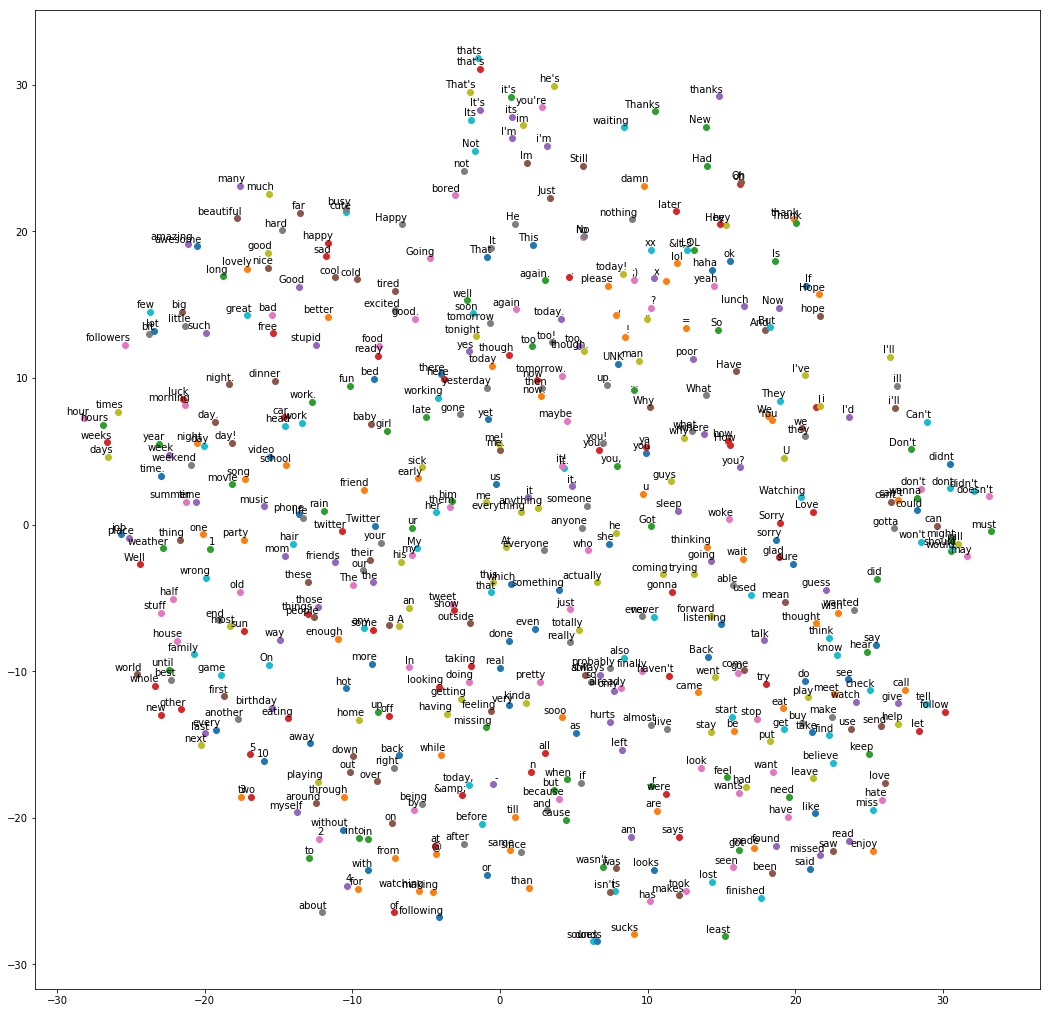

In [32]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels)
    plt.show()

except ImportError:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')

## Average length of tweets in the training data

In [247]:
avg_lengths = []

In [248]:
for tweet in X_all:
    avg_lengths.append(len( tweet.split(' ') ))

In [249]:
np.mean(avg_lengths) # avg tweet lenth use 20

14.47882633604711

### Create a training matrix that has the vector for each word in each tweet

In [42]:
def create_training_matrix(tweet_matrix, word_dictionary_idx_lookup, embedding_size, tweet_length):
    """Returns a 3 dimensional tensor
    Dim 1 (rows): the word from each tweet
    dim 2 (columns): the vector representation of that word (128 dimensions)
    dim 3( depth): the total number of tweets in the dataset.
    
    PARAMS:
    tweet_matrix, - a matrix that contains the tweets, a list of strings
    embedding, - the final word2vec embedding of the tweets
    word_dictionary_idx_lookup, - the index of each word for the embedding
    g,   - the tensorflow graph
    embedding_size - max num. features for embedding)
    tweet_length - how many vectors to return for each tweet"""
    final_matrix = np.zeros((len(tweet_matrix),tweet_length),dtype=np.int32)
    for tweet_idx,tweet in enumerate(tweet_matrix):
        tweet_idxs = []
        for word in tweet.strip(' ').lower().split(' '): # go through each word
            if len(tweet_idxs)>=tweet_length: 
                break
            elif word =='':
                pass
            else:
                try:
                    tweet_idxs.append(int(word_dictionary_idx_lookup[word]))
                except: # unknown word
                    tweet_idxs.append(int(0)) # vector for UNK words, unknown
        while len(tweet_idxs)<tweet_length:
            tweet_idxs.append(int(1)) ## fill in with blanks
            
        # now, find the vectors for each word
#         with tf.Session(graph=g) as sess:
#             tweet_embedding = tf.nn.embedding_lookup(embedding, tweet_idxs).eval()
        #final_matrix[:,:,tweet_idx] = tweet_embedding
    
        final_matrix[tweet_idx,:] = tweet_idxs
        if tweet_idx % 100_000 ==0:
            print(f"Finished number {tweet_idx+1} out of {len(tweet_matrix)}")
    return final_matrix
        

In [608]:
# save dictionary
with open("./embedding_information/dictionary_lookup_ids",'wb') as fp:
    pickle.dump(dictionary,fp)

In [609]:
tweet_idxs_matrix_train = create_training_matrix(X_train_lstm,  dictionary, graph ,embedding_size, max_tweet_length)

Finished number 1 out of 1262889
Finished number 100001 out of 1262889
Finished number 200001 out of 1262889
Finished number 300001 out of 1262889
Finished number 400001 out of 1262889
Finished number 500001 out of 1262889
Finished number 600001 out of 1262889
Finished number 700001 out of 1262889
Finished number 800001 out of 1262889
Finished number 900001 out of 1262889
Finished number 1000001 out of 1262889
Finished number 1100001 out of 1262889
Finished number 1200001 out of 1262889


In [47]:
tweet_idxs_matrix_test = create_training_matrix(X_test_lstm,  dictionary, embedding_size, max_tweet_length)

Finished number 1 out of 315723
Finished number 100001 out of 315723
Finished number 200001 out of 315723
Finished number 300001 out of 315723


In [48]:
X_small_train[0], y_small_train[0]

('                     is so sad for my APL friend.............',
 array([0, 1]))

In [87]:

tweet_idxs_matrix_train_SMALL = create_training_matrix(X_small_train.ravel(),  dictionary, embedding_size, max_tweet_length)


Finished number 1 out of 662


#### Define the LSTM graph

In [53]:
 final_embeddings.shape

(50000, 128)

In [54]:
batchSize = 32
lstmUnits = 256
numClasses = 2
numDimensions = 128 # size of embedding
iterations = 150_000

In [ ]:
lstm_graph = tf.Graph()
tf.reset_default_graph()
with lstm_graph.as_default():


    input_labels = tf.placeholder(tf.int64, [batchSize, numClasses], name='placeholder_labels')
    input_data = tf.placeholder(tf.int64, [batchSize, max_tweet_length], name='placeholder_input_data')
    data = tf.Variable(tf.zeros([batchSize, max_tweet_length, numDimensions]),dtype=tf.float32, name='data1')
    data_lookup = tf.nn.embedding_lookup(final_embeddings, input_data)
    # ensure the data is float32 type
    data = tf.cast(data_lookup, tf.float32)
    #print(data.shape,'data shape')
    lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
    value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)
    # multiple the output of the RNN cell
    weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
    bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
    value = tf.transpose(value, [1, 0, 2])
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    prediction = (tf.matmul(last, weight) + bias)
    #prediction = tf.nn.sigmoid((tf.matmul(last, weight) + bias)) # trying to get to logits
    # check accuracy during training
    arg_pred =  tf.argmax(prediction,1)
    arg_labels = tf.argmax(input_labels,1)
    correctPred = tf.equal(arg_pred,arg_labels)
    accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
    # loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=input_labels))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    
    
    # train the network
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saveDir = 'tensorflow/lstm_model_overfit'
    
    # tensorboard
    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/overfit100-n2/" 
    writer = tf.summary.FileWriter(logdir, sess.graph)
    
    # setup the generators
    #gen_test = batch_generator(batchSize, tweet_idxs_matrix_test, y_test_lstm)
    gen_train = batch_generator(batchSize, tweet_idxs_matrix_train_SMALL,  y_small_train)
    #gen_train = batch_generator(batchSize, tweet_idxs_matrix_train,  y_train_lstm)
    
    # try to load existing model
#     try:
#         saver.restore(sess, tf.train.latest_checkpoint("tensorflow/"))
#         print('Finished loading model')
#     except Exception as e:
#         print(e)
#         pass
        
    for i in range(iterations):
        
        #Next Batch of reviews
        nextBatch, nextBatchLabels = next(gen_train)
        try:
            sess.run(optimizer, {input_data: nextBatch, input_labels: nextBatchLabels})
        except Exception as e:
            # need a new generator
            gen_train = batch_generator(batchSize, tweet_idxs_matrix_train_SMALL,  y_small_train)
            #Next Batch of reviews
            nextBatch, nextBatchLabels = next(gen_train)
            sess.run(optimizer, {input_data: nextBatch, input_labels: nextBatchLabels})

                

        #Write summary to Tensorboard
        if (i % 50 == 0):
            print(f'Iteration {i} out of {iterations}')
            try:
                #print(nextBatch.shape,'nextbatch shape')
                #print(nextBatchLabels.shape,'nextBatchLabels shape')
                summary,pred,agg_pred, in_labels = sess.run([merged,prediction,arg_pred,arg_labels], {input_data: nextBatch, input_labels: nextBatchLabels})
                #print(pred,'prediciton')
                print(agg_pred, ' aggregate prediction')
                print(in_labels,'labels')
                writer.add_summary(summary, i)
            except Exception as e:
                print(e) 
                # need a new generator
                #gen_test = batch_generator(batchSize, tweet_idxs_matrix_test, y_test_lstm)
                gen_train = batch_generator(batchSize, tweet_idxs_matrix_train_SMALL,  y_small_train)
                #Next Batch of reviews
                nextBatch, nextBatchLabels = next(gen_train)
                
                summary,pred = sess.run([merged, prediction], {input_data: nextBatch, input_labels: nextBatchLabels})
                writer.add_summary(summary, i)

        #Save the network every 10,000 training iterations
        if (i % 10_000 == 0 and i != 0):
            save_path = saver.save(sess, saveDir, global_step=i)
            print("saved to %s" % save_path)
    writer.close()
        


Iteration 0 out of 150000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]  aggregate prediction
[0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1] labels
Iteration 50 out of 150000
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]  aggregate prediction
[0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0] labels
Iteration 100 out of 150000
[0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  aggregate prediction
[0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1] labels
Iteration 150 out of 150000
[1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1]  aggregate prediction
[1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0] labels
Iteration 200 out of 150000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]  aggregate prediction
[1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0] labels
Iteration 250 out of 150000
[0 1 1 1 1 0 1 0 1 1 1 1 1 1 1

Iteration 2200 out of 150000
[1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0]  aggregate prediction
[0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1] labels
Iteration 2250 out of 150000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0]  aggregate prediction
[0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1] labels
Iteration 2300 out of 150000
[1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0]  aggregate prediction
[0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0] labels
Iteration 2350 out of 150000
[1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1]  aggregate prediction
[1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1] labels
Iteration 2400 out of 150000
[1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]  aggregate prediction
[1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1] labels
Iteration 2450 out of 150000
[0 0 1 1 1 1 1 1 1 0 

Iteration 4400 out of 150000
[1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1]  aggregate prediction
[1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1] labels
Iteration 4450 out of 150000
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  aggregate prediction
[1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0] labels
Iteration 4500 out of 150000
[1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1]  aggregate prediction
[0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0] labels
Iteration 4550 out of 150000
[0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]  aggregate prediction
[1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0] labels
Iteration 4600 out of 150000
[0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0]  aggregate prediction
[0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1] labels
Iteration 4650 out of 150000
[0 1 1 0 1 0 1 0 1 0 

Iteration 6600 out of 150000
[1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1]  aggregate prediction
[0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0] labels
Iteration 6650 out of 150000
[1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0]  aggregate prediction
[0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1] labels
Iteration 6700 out of 150000
[0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0]  aggregate prediction
[0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1] labels
Iteration 6750 out of 150000
[1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]  aggregate prediction
[0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1] labels
Iteration 6800 out of 150000
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0]  aggregate prediction
[0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1] labels
Iteration 6850 out of 150000
[0 0 1 0 1 1 0 0 1 0 

Iteration 8800 out of 150000
[0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0]  aggregate prediction
[1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1] labels
Iteration 8850 out of 150000
[0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1]  aggregate prediction
[1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0] labels
Iteration 8900 out of 150000
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0]  aggregate prediction
[1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1] labels
Iteration 8950 out of 150000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]  aggregate prediction
[0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1] labels
Iteration 9000 out of 150000
[0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0]  aggregate prediction
[1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0] labels
Iteration 9050 out of 150000
[1 0 0 0 0 0 0 0 0 1 

In [ ]:
gen_train = batch_generator(batchSize, tweet_idxs_matrix_train_SMALL,  y_small_train)

In [722]:
x,y  = next(gen_train)

In [723]:
x.shape

(32, 20)

In [724]:
tweet_idxs_matrix_train_SMALL.shape

(100, 20)

In [725]:
x[13][0]

46

In [730]:
type(y_small_train[0][0])

numpy.int64

In [726]:
X_small_train[0].strip(' ').lower().split(' ')

['is', 'so', 'sad', 'for', 'my', 'apl', 'friend.............']

In [654]:
[reverse_dictionary[i] for i in x[20]]

['In',
 'case',
 'I',
 'feel',
 'emo',
 'in',
 'camp',
 'UNK',
 'a',
 'wee',
 'bit',
 'of',
 'it',
 'UNK',
 'bringing',
 'in',
 'the',
 'Human',
 'Rights',
 'Watch']

In [655]:
y[20]

array([1, 0])

In [536]:
tweet_idxs_matrix_train_SMALL.shape

(1000, 20)

In [546]:
g =  batch_generator(batchSize, tweet_idxs_matrix_train,  y_train_lstm)

In [547]:
x_, y_ = next(g)

In [548]:
x_.shape

(32, 20)

In [549]:
y_.shape

(32, 2)